In [53]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

%matplotlib inline
import sklearn.metrics as skl_metrics
from IPython.display import display, Markdown

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "/mnt/c/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
NLST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

## Get training data for each model

In [55]:
## Replace with v2 when Chansey is back up :/
kiran_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demo_v1_w6preds.csv")
kiran_data = utils.prep_nlst_preds(kiran_nodule, scanlevel=True, sybil=False, tijmen=False)
print(len(kiran_data), "Scans")

10183 Scans


In [8]:
with open(f'{NLST_PREDS}/nlst_demo_v1_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [18]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
cols_list = cols_num + cols_cat

Get data for Tijmen's linear layer.

In [ ]:
tijmen_train = kiran_data[kiran_data['Thijmen_mean'].isna()]
print("train:", len(tijmen_train), "Nodules")
tijmen_val = kiran_data[~kiran_data['Thijmen_mean'].isna()]
print("val:", len(tijmen_val), "Nodules")

train: 8121 Nodules
val: 2062 Nodules


In [62]:
training_sets = {
    'Kiran': kiran_data,
    'Tijmen': tijmen_train
}

## Get Demographic splits

In [95]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, training_sets=training_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, training_sets)
            if dispdf: display(df)

            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-2:] + dfcols[:-2]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

### Categorical columns

In [129]:
def cat_dist_df(c='Gender', training_sets=training_sets):
    dfdict = {}
    for m in training_sets:
        dfdict[f"{m}_freq"] = training_sets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * training_sets[m][c].value_counts(normalize=True, dropna=False).round(6)
    
    for i, m1 in enumerate(training_sets):
        for j, m2 in enumerate(training_sets):
            if j > i:
                dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)

    df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [130]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, training_sets)

In [135]:
display(cat_demo_splits.sort_values(by='diff_norm_Kiran_Tijmen', ascending=False))
cat_demo_splits.sort_values(by='diff_norm_Kiran_Tijmen', ascending=True)

,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,diff_freq_Kiran_Tijmen,diff_norm_Kiran_Tijmen
114,diaghype,0.0,6602,64.8335,5225.0,64.3394,1377.0,0.4941
41,wrkasbe,1.0,481,4.7236,345.0,4.2482,136.0,0.4754
2,marital,3.0,864,8.4847,659.0,8.1148,205.0,0.3699
30,cigsmok,1.0,5088,49.9656,4028.0,49.5998,1060.0,0.3658
8,educat,3.0,2538,24.9239,2001.0,24.6398,537.0,0.2841
...,...,...,...,...,...,...,...,...
29,cigsmok,0.0,5095,50.0344,4093.0,50.4002,1002.0,-0.3658
10,educat,5.0,2287,22.4590,1858.0,22.8790,429.0,-0.4200
40,wrkasbe,0.0,9694,95.1979,7769.0,95.6656,1925.0,-0.4677
115,diaghype,1.0,3562,34.9799,2881.0,35.4759,681.0,-0.4960


,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,diff_freq_Kiran_Tijmen,diff_norm_Kiran_Tijmen
115,diaghype,1.0,3562,34.9799,2881.0,35.4759,681.0,-0.4960
40,wrkasbe,0.0,9694,95.1979,7769.0,95.6656,1925.0,-0.4677
10,educat,5.0,2287,22.4590,1858.0,22.8790,429.0,-0.4200
29,cigsmok,0.0,5095,50.0344,4093.0,50.4002,1002.0,-0.3658
4,marital,5.0,1904,18.6978,1546.0,19.0371,358.0,-0.3393
...,...,...,...,...,...,...,...,...
30,cigsmok,1.0,5088,49.9656,4028.0,49.5998,1060.0,0.3658
2,marital,3.0,864,8.4847,659.0,8.1148,205.0,0.3699
41,wrkasbe,1.0,481,4.7236,345.0,4.2482,136.0,0.4754
114,diaghype,0.0,6602,64.8335,5225.0,64.3394,1377.0,0.4941


### Numerical columns

In [132]:
def num_dist_df(c='Gender', training_sets=training_sets):
    dfdict = {}
    for m in training_sets:
        dfdict[f"{m}"] = training_sets[m][c].describe().round(4)
    
    for i, m1 in enumerate(training_sets):
        for j, m2 in enumerate(training_sets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index='count', inplace=True)
    return df

In [133]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, training_sets)

In [136]:
display(num_demo_splits.sort_values(by='diff_Kiran_Tijmen', ascending=False).query('diff_Kiran_Tijmen > 0'))
num_demo_splits.sort_values(by='diff_Kiran_Tijmen', ascending=True).query('diff_Kiran_Tijmen < 0')

,attribute,value,Kiran,Tijmen,diff_Kiran_Tijmen
21,pkyr,25%,40.5000,40.0000,0.5000
48,smokeyr,std,7.3690,7.3377,0.0313
18,Age,mean,63.2049,63.1751,0.0298
39,smokeday,mean,28.5740,28.5444,0.0296
46,smokeyr,mean,41.0055,40.9844,0.0211
4,height,mean,67.8867,67.8719,0.0148
25,pkyr,mean,57.9729,57.9599,0.0130
20,Age,std,5.2401,5.2387,0.0014


,attribute,value,Kiran,Tijmen,diff_Kiran_Tijmen
27,pkyr,std,24.6293,24.9646,-0.3353
11,weight,mean,181.8113,181.8669,-0.0556
6,height,std,3.9438,3.9786,-0.0348
34,smokeage,std,3.5359,3.5449,-0.0090
13,weight,std,38.9777,38.9825,-0.0048
41,smokeday,std,11.4641,11.4674,-0.0033
32,smokeage,mean,16.5991,16.5993,-0.0002


## Demographic correlations

In [137]:
correlations = {m: training_sets[m][cols_list].corr(method='pearson').round(2) for m in training_sets}
correlations['diff_Kiran_Tijmen'] = correlations['Kiran'] - correlations['Tijmen']

### Kiran

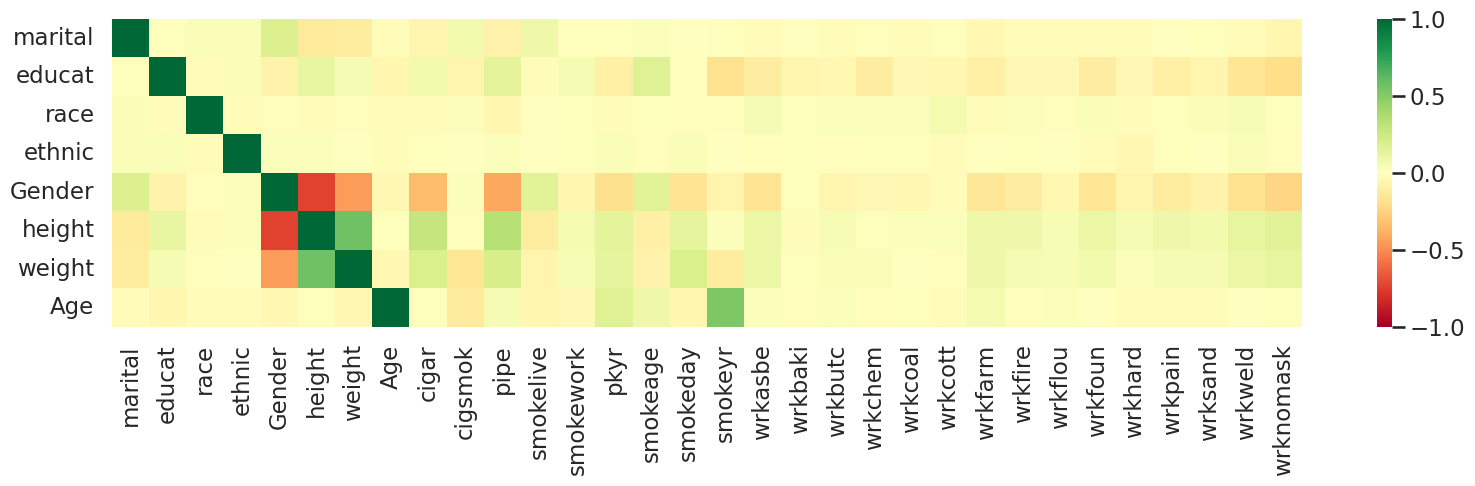

### Tijmen

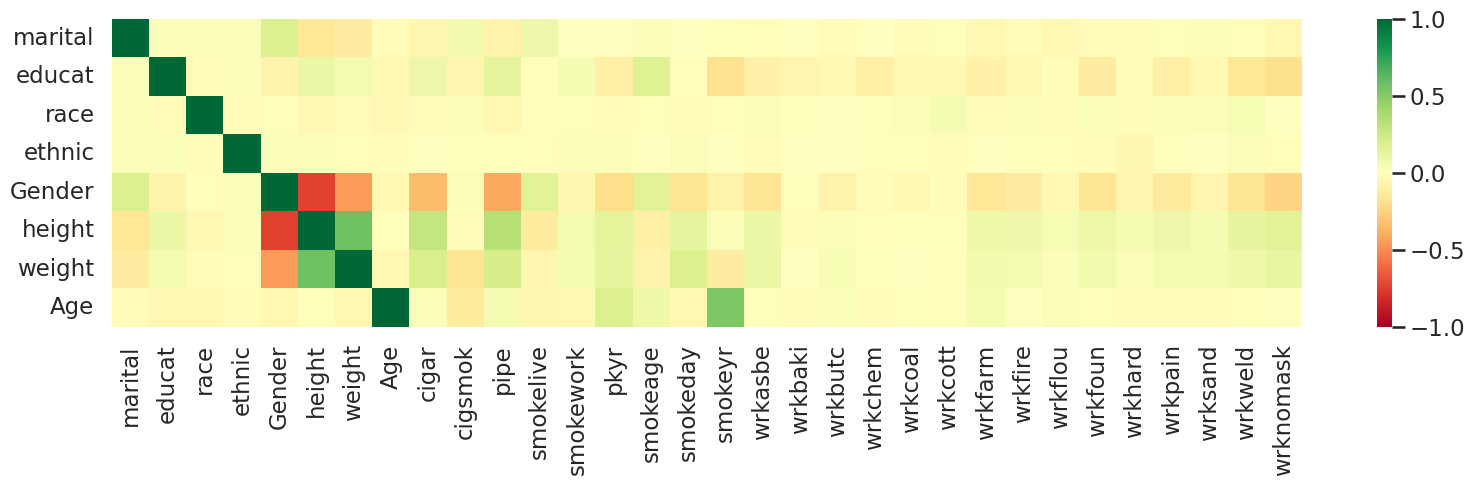

### diff_Kiran_Tijmen

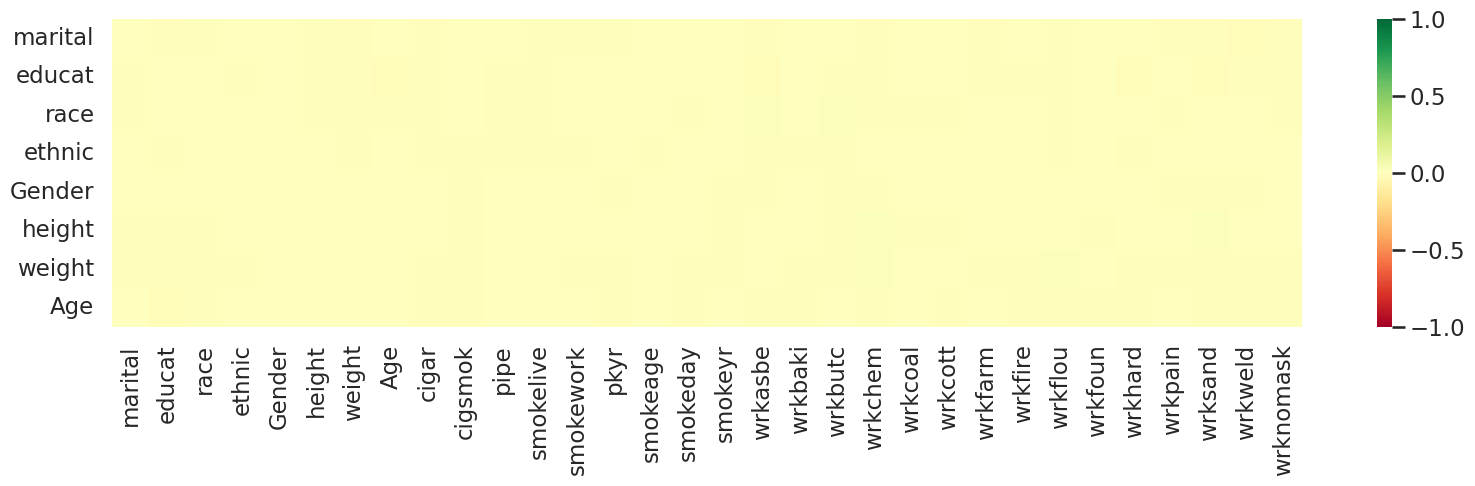

In [149]:
for m in correlations:
    corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
    corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['work']
    # corr_cols, corr_rows = cols_list, cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()